In [248]:
%reset

In [249]:
import sys
from pathlib import Path

# Current working dir  …/DGRB Scripts/Test - sbi for 1 SFG and 1 mAGN…
# parent[0] → …/DGRB Scripts
# parent[1] → …/home/users/ids29           ← where “DGRB/” lives
package_path = Path.cwd().parents[1] / "DGRB"   # /home/users/ids29/DGRB

sys.path.insert(0, str(package_path))           # make it import-able


In [250]:
import aegis
import numpy as np
import healpy as hp
import torch
import pickle as pk
from astropy import units as u
from astropy import constants as c
import matplotlib.pyplot as plt
from os import listdir
import os
from sbi.inference import SNPE #, prepare_for_sbi #, simulate_for_sbi
from sbi import utils as utils
from sbi import analysis as analysis
# from sbi.inference.base import infer
from getdist import plots, MCSamples
import pickle
from scipy.stats import norm, skew, kurtosis, spearmanr
from scipy.integrate import quad, simpson
from joblib import Parallel, delayed
from torch.optim import AdamW
from sbi.neural_nets import posterior_nn

%matplotlib inline

In [251]:
grains=1000
num_workers = 48  # or your chosen parallel worker count

NUM_ROUNDS     = 10
SIMS_PER_ROUND = 96
POST_SAMPLES   = 10_000            # how many samples for corner plot
LOW  = torch.tensor([-5.0, -6.5])
HIGH = torch.tensor([ -1.0, -2.5])
LABELS = [r"\log_{10}\Phi_{\rm SFG}", r"\log_{10}\Phi_{\rm mAGN}"]

theta_test = torch.tensor([-2.08, -3.749])

In [252]:
parameter_range = [[], []]
abundance_luminosity_and_spectrum_list = []
source_class_list = []
parameter_names = []
energy_range = [1000, 100000] #MeV
energy_range_gen = [energy_range[0]*0.5, energy_range[1]*18]
max_radius = 8.5 + 20*2 #kpc
exposure = 2000*10*0.2 #cm^2 yr
flux_cut = 1e-9 #photons/cm^2/s
angular_cut = np.pi #10*u.deg.to('rad') #degrees
angular_cut_gen = np.pi #angular_cut*1.5
lat_cut = 0 #2*u.deg.to('rad') #degrees
lat_cut_gen = lat_cut*0.5

In [253]:
my_cosmology = 'Planck18'
z_range = [0, 14]
luminosity_range = 10.0**np.array([37, 50]) # Minimum value set by considering Andromeda distance using Fermi as benchmark and receiving 0.1 photon at detector side
my_AEGIS = aegis.aegis(abundance_luminosity_and_spectrum_list, source_class_list, parameter_range, energy_range, luminosity_range, max_radius, exposure, angular_cut, lat_cut, flux_cut, energy_range_gen=energy_range_gen, cosmology = my_cosmology, z_range = z_range, verbose = False)
my_AEGIS.angular_cut_gen, my_AEGIS.lat_cut_gen = angular_cut_gen, lat_cut_gen

In [254]:
Gamma_SFG = 2.2
gamma_energy_bounds = energy_range_gen  # in MeV
E_photon_MeV_SFG = ((-Gamma_SFG + 1) / (-Gamma_SFG + 2) *
                (gamma_energy_bounds[1]**(-Gamma_SFG + 2) - gamma_energy_bounds[0]**(-Gamma_SFG + 2)) /
                (gamma_energy_bounds[1]**(-Gamma_SFG + 1) - gamma_energy_bounds[0]**(-Gamma_SFG + 1))) # in MeV
E_photon_SFG = E_photon_MeV_SFG * 1.60218e-6  # erg

Gamma_mAGN = 2.2 # enforced by user to match SFG spectrum (actually should 2.25)
gamma_energy_bounds = energy_range_gen  # in MeV
E_photon_MeV_mAGN = ((-Gamma_mAGN + 1) / (-Gamma_mAGN + 2) *
                (gamma_energy_bounds[1]**(-Gamma_mAGN + 2) - gamma_energy_bounds[0]**(-Gamma_mAGN + 2)) /
                (gamma_energy_bounds[1]**(-Gamma_mAGN + 1) - gamma_energy_bounds[0]**(-Gamma_mAGN + 1))) # MeV
E_photon_mAGN = E_photon_MeV_mAGN * 1.60218e-6  # erg

res = int(1e4)
log_LIRs = np.linspace(-5, 25, res)
log_L5Gs = np.linspace(20, 55, res)

In [255]:
def ZL_SFG1(z, l, params):


    log_PhiStar = params[0]
    Phi_star = 10**log_PhiStar

    l_erg = l * E_photon_SFG # erg/s
    LFs = np.zeros_like(l)

    def Phi_IR(log_LIR): #log_LIR = log_10(L_IR / solar_luminosity) # unitless

        # from Table 8 in Gruppioni et al.
        # Phi_star = 10**(-2.08) # Mpc^{-3} dex^{-1}
        Lstar = 10**(9.46) # Solar luminosity
        alpha = 1.00
        sigma = 0.50

        LIR = 10**log_LIR # solar luminosity

        Phi_IR = Phi_star * (LIR / Lstar)**(1 - alpha) * np.exp(-1 / (2 * sigma**2) * (np.log10(1 + LIR / Lstar))**2) # from Gruppioni paper eqn (3)  	

        return Phi_IR

    def PDF_log_Lgamma_given_log_LIR(log_LIR, log_Lgamma): #log_LIR = log_10(L_IR / solar_luminosity) # unitless
        LIR_solar_luminosity = 10**log_LIR # Solar luminosity
        L_IR_erg_second = LIR_solar_luminosity * 3.826e33 # erg/s

        a = 1.09
        g = 40.8
        sigma_SF = 0.202 

        mean = g + a * np.log10(L_IR_erg_second / 1e45)
        std = sigma_SF

        return norm.pdf(log_Lgamma, loc=mean, scale=std)

    def integrand(PhiIR_of_logLIRs, log_LIRs, log_Lgamma):
        return PhiIR_of_logLIRs * PDF_log_Lgamma_given_log_LIR(log_LIRs, log_Lgamma)

    PhiIR_of_logLIRs = Phi_IR(log_LIRs)

    for i in range(LFs.shape[0]):
        for j in range(LFs.shape[1]):
            LFs[i,j] = simpson(integrand(PhiIR_of_logLIRs, log_LIRs, np.log10(l_erg[i,j])), x=log_LIRs)
    return 1e-9 / np.log(10) / l * LFs # LF has spatial units of Mpc^{-3}. We need to convert this to kpc^{-3}. Hence the factor of 1e-9


def spec_SFG1(energy, params):
    Gamma = 2.2
    return energy**(-Gamma)

In [256]:
def ZL_mAGN(z, l, params):

    log_phi1 = params[1]
    phi1 = 10**log_phi1

    l_erg = l * E_photon_mAGN # erg/s
    LFs = np.zeros_like(l)

    def Phi_5G(log_L5G, z): #log_L5G = log_10(L_5GHz / (erg/s)) # unitless
        #Output is in Mpc^{-3}

        L_5G = 10**log_L5G # erg/s
        radio_bandwidth = 4.87e9 # measured in Hz # width of radio band centered around blueshifted frequency of 5GHz 
        diff_L5G = L_5G / radio_bandwidth * 1e-7 # measured in W/Hz # Converted erg to Joule # luminosity per unit frequency

        # Values taken from Table 4 of Yuan 2018 paper. Second row.
        p1 = 2.085
        p2 = -4.602
        z_c = 0.893
        k1 = 1.744
        e1 = ( (1+z_c)**p1 + (1+z_c)**p2 ) / ( ((1+z_c)/(1+z))**p1 + ((1+z_c)/(1+z))**p2 )
        e2 = (1+z)**k1
        # phi1 = 10**(-3.749) # Mpc^{-3}
        L_star = 10**21.592 # W/Hz
        beta = 0.139
        gamma = 0.878

        # From Yuan 2018 paper equation 21
        # Note that this is dN/dV dlog(diff_5G). But this is also equal to dN/dV dlog(L_5G) because the radio bandwidth is fixed.
        Phi_5G = e1 * phi1 * ( (diff_L5G / (e2 * L_star))**beta + (diff_L5G / (e2 * L_star))**gamma )**-1

        return Phi_5G
    

    def PDF_log_Lgamma_given_log_L5G(log_L5G, log_Lgamma): #log_L5G = log_10(L_5GHz / (erg/s)) # unitless
        L_5GHz = 10**log_L5G # erg/s

        b = 0.78
        d = 40.78
        sigma_mAGN = 0.880

        mean = d + b * np.log10(L_5GHz / 1e40)
        std = sigma_mAGN

        return norm.pdf(log_Lgamma, loc=mean, scale=std)
    

    def integrand(log_L5G, z, log_Lgamma):
        return Phi_5G(log_L5G, z) * PDF_log_Lgamma_given_log_L5G(log_L5G, log_Lgamma)
    


    for i in range(LFs.shape[0]):
        for j in range(LFs.shape[1]):
            LFs[i,j] = simpson(integrand(log_L5Gs, z[i,j], np.log10(l_erg[i,j])), x=log_L5Gs)


    return 1e-9 / np.log(10) / l * LFs # LF has spatial units of Mpc^{-3}. We need to convert this to kpc^{-3}. Hence the factor of 1e-9



def spec_mAGN(energy, params):
    Gamma = 2.2 #modified sepctrum to match the SFG spectrum
    return energy**(-Gamma)

In [257]:
als_SFG1 = [ZL_SFG1, spec_SFG1]
als_mAGN = [ZL_mAGN, spec_mAGN]
my_AEGIS.abun_lum_spec = [als_SFG1, als_mAGN]
my_AEGIS.source_class_list = ['extragalactic_isotropic_faint_single_spectrum', 'extragalactic_isotropic_faint_single_spectrum']

In [258]:
# a simple simulator with the total number of photons as the summary statistic
def simulate_raw_photon_data(params):

    input_params = params.numpy()

    source_info = my_AEGIS.create_sources(input_params, grains=grains, epsilon=1e-2)
    photon_info = my_AEGIS.generate_photons_from_sources(input_params, source_info, grains=grains) 
    obs_info = {'psf_fits_path': '../../DGRB/FERMI_files/psf_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'edisp_fits_path': '../../DGRB/FERMI_files/edisp_P8R3_ULTRACLEANVETO_V2_PSF.fits', 'event_type': 'PSF3', 'exposure_map': None}
    obs_photon_info = my_AEGIS.mock_observe(photon_info, obs_info)
    
    return obs_photon_info

In [259]:
def compute_moments(values):
    """Compute the mean and variance of the energies."""
    mean = np.mean(values)
    var = np.var(values)
    skewness = skew(values)
    kurt = kurtosis(values)
    return mean, var, skewness, kurt

def compute_quantiles(values, quantiles=[10, 25, 50, 75, 90]):
    """
    Compute the specified quantiles (in percent).
    For example, the 25th quantile is the energy such that 25% of the data lies below it.
    Returns a dictionary mapping percentiles to values.
    """
    q_values = np.percentile(values, quantiles)
    return dict(zip(quantiles, q_values))

def normalize_quantiles(q_dict, val_min, val_max):
    """
    Normalize quantile values from a dictionary using min-max normalization.
    """
    norm_q = {perc: (val - val_min) / (val_max - val_min) for perc, val in q_dict.items()}
    return norm_q




def effective_spectral_index(energies, E_lower):
    """
    Compute effective spectral index via MLE.
    Returns np.nan if there are no photons.
    """
    energies = np.array(energies)
    n = len(energies)
    if n == 0:
        return np.nan
    sum_logs = np.sum(np.log(energies / E_lower))
    return 1 + n / sum_logs

def smooth_binned_gamma(binned_gamma, counts, global_gamma, min_count=6):
    """
    Smooth binned effective spectral indices if the count in a bin is low.
    
    Parameters:
      binned_gamma : array-like
          Array of spectral indices per energy bin (may contain np.nan for empty bins).
      counts : array-like
          Array of photon counts per bin.
      global_gamma : float
          Global effective spectral index, used as fallback.
      min_count : int
          Minimum photon count required to trust a bin.
    
    Returns:
      smoothed_gamma : numpy array with smoothed spectral index values.
    """
    binned_gamma = np.array(binned_gamma)
    counts = np.array(counts)
    num_bins = len(binned_gamma)
    smoothed_gamma = binned_gamma.copy()

    # Loop over each bin.
    for i in range(num_bins):
        if counts[i] < min_count or np.isnan(binned_gamma[i]):
            indices = [i]
            if i > 0:
                indices.append(i-1)
            if i < num_bins - 1:
                indices.append(i+1)
            indices = list(set(indices))  # ensure uniqueness
            
            # Only include indices with non-NaN values
            valid_indices = [j for j in indices if not np.isnan(binned_gamma[j])]
            if valid_indices:
                # Use the counts as weights. If any count is zero, it's fine; it will reduce the weight.
                weights = np.array([counts[j] for j in valid_indices], dtype=np.float32)
                # If all weights sum to 0, default to global_gamma.
                if np.sum(weights) > 0:
                    smoothed_gamma[i] = np.average(binned_gamma[valid_indices], weights=weights)
                else:
                    smoothed_gamma[i] = global_gamma
            else:
                # If none of the neighboring bins have a valid estimate, fallback to global_gamma.
                smoothed_gamma[i] = global_gamma
    return smoothed_gamma

def compute_binned_effective_spectral_indices(energies, num_bins, energy_range):
    """
    Divide the energy range into logarithmic bins and compute the effective spectral index in each bin.
    For bins with few photons (count < min_count) or empty bins, apply smoothing by averaging with neighboring bins.
    
    Returns:
      smoothed_gamma : 1D array containing the (possibly smoothed) spectral index for each bin.
      global_gamma  : Effective spectral index computed using all energies (with the lowest bin edge as E_lower).
      counts        : Raw photon counts per bin.
    """
    bins = np.geomspace(energy_range[0], energy_range[1], num_bins + 1)
    binned_gamma = []
    counts = []  # photon counts per bin

    # Loop over bins
    for i in range(len(bins) - 1):
        mask = (energies >= bins[i]) & (energies < bins[i+1])
        energies_bin = energies[mask]
        counts.append(len(energies_bin))
        # Compute gamma for the bin; if the bin is empty, effective_spectral_index returns np.nan.
        gamma = effective_spectral_index(energies_bin, E_lower=bins[i])
        binned_gamma.append(gamma)
    
    binned_gamma = np.array(binned_gamma)
    counts = np.array(counts)
    
    # Compute the global effective spectral index over all energies using the first bin's lower edge.
    global_gamma = effective_spectral_index(energies, E_lower=bins[0])
    
    # Smooth the binned_gamma using neighboring bins if counts in a bin are low.
    smoothed_gamma = smooth_binned_gamma(binned_gamma, counts, global_gamma, min_count=6)
    
    return smoothed_gamma, global_gamma, counts




def normalize_binned_gamma(binned_gamma, global_gamma, mode='ratio'):
    """
    Normalize the binned effective spectral indices relative to the global effective spectral index.
    
    Parameters:
      binned_gamma : np.array
          Array of effective spectral indices for each energy bin.
      global_gamma : float
          The global effective spectral index computed over the entire energy range.
      mode : str, optional
          'ratio' for normalized_binned_gamma = binned_gamma / global_gamma,
          'difference' for normalized_binned_gamma = (binned_gamma - global_gamma)/global_gamma.
          Default is 'ratio'.
    
    Returns:
      normalized_binned_gamma : np.array
    """
    if mode == 'ratio':
        # Return ratio relative to global spectral index
        normalized_binned_gamma = binned_gamma / global_gamma
    elif mode == 'difference':
        # Return relative differences with baseline 0
        normalized_binned_gamma = (binned_gamma - global_gamma) / global_gamma
    else:
        raise ValueError("Unknown mode for normalization. Choose 'ratio' or 'difference'.")
    return normalized_binned_gamma


# --- concise, log-binned 1-D energy histogram ---------------------------
def compute_energy_only_histogram(energies, num_bins, energy_range=(1000, 100_000)):
    """
    Log-bin photon energies (MeV) into `num_bins` and return raw counts.

    Parameters
    ----------
    energies      : 1-D iterable (list / np.ndarray / torch.Tensor)
    num_bins      : int, number of logarithmic bins
    energy_range  : (low, high) edges in MeV  (default 1–100 GeV)

    Returns
    -------
    hist : 1-D np.ndarray length `num_bins`  (integer counts)
    """
    edges = np.geomspace(energy_range[0], energy_range[1], num_bins + 1, dtype=np.float32)
    hist, _ = np.histogram(np.asarray(energies, dtype=np.float32), bins=edges)
    return hist.astype(np.float32)


def normalize_energy_only_hist(energy_only_hist):
    """
    Normalize a 1D histogram so it sums to 1.
    """
    total = np.sum(energy_only_hist) # this is the total number of photons in the energy-only histogram
    if total == 0:
        return energy_only_hist  # or handle the zero-case as needed
    return energy_only_hist / total

def compute_sub_statistics(energies, counts, N_Ebins):
    """
    Given an array of photon energies (all between 1 and 100 GeV), compute a set of summary statistics:
      1. Mean energy.
      2. Variance of energy.
      3. Quantiles: 10%, 25%, 50%, 75%, and 90%.
      4. Effective spectral index estimated from the data.
      
    Returns the statistics in a dictionary and also a flattened torch tensor.
    """
    # 1. Mean and variance
    mean_E, var_E, skewness_E, kurt_E  = compute_moments(energies)
    mean_counts, var_counts, skewness_counts, kurt_counts  = compute_moments(counts)
    
    # 2. Quantiles
    quant_dict_E = compute_quantiles(energies)  # This returns a dict like {10: val, 25: val, ...}
    norm_quant_dict_E = normalize_quantiles(quant_dict_E, val_min=energy_range[0], val_max=energy_range[1])

    quant_dict_counts = compute_quantiles(counts)  # This returns a dict like {10: val, 25: val, ...}
    norm_quant_dict_counts = normalize_quantiles(quant_dict_counts, val_min=0, val_max=np.max(counts))

    energy_only_hist = compute_energy_only_histogram(energies, num_bins=N_Ebins, energy_range=energy_range)

    binned_gamma, global_gamma, energy_only_hist = compute_binned_effective_spectral_indices(energies, num_bins=N_Ebins, energy_range=energy_range)
    norm_binned_gamma = normalize_binned_gamma(binned_gamma, global_gamma, mode='ratio')
    norm_energy_only_hist = normalize_energy_only_hist(energy_only_hist)
    
    # If you want to pass the summary statistic to sbi, it is best to use a fixed-size vector (e.g., a torch tensor).
    # For example, arrange the stats in a consistent order:
    scalars  = np.array([
        energies.size, # total number of photons
        mean_E, var_E , skewness_E, kurt_E,
        mean_counts, var_counts, skewness_counts, kurt_counts,
        global_gamma
    ], dtype=np.float32)

    
    return scalars , norm_quant_dict_E, norm_quant_dict_counts, norm_binned_gamma, norm_energy_only_hist

def normalize_energy_dependent_hist(energy_dependent_hist, total_pixels):
    """
    Normalize a 2D histogram so that each column sums to 1.
    total_pixels: the fixed number of pixels (for example, len(roi_pix_i))
    """
    # If the histogram is of shape (N_countbins, N_Ebins),
    # each column should ideally sum to total_pixels.
    normalized_hist = energy_dependent_hist / total_pixels
    return normalized_hist

In [260]:
# a simple simulator with the total number of photons as the summary statistic
def compute_summary_statistics(photon_info):

    N_side = 2**6
    #parameters for the summary statistic
    
    center_mask = 10 #deg 
    lat_mask = 5 #deg 
    N_Ebins = 20
    # Ebinspace = 'log'#'linear'
    N_countbins = 10
    countbinspace = 'custom'#'linear'
    mincount_2D_hist, maxcount_2D_hist = 0, 38 # For energy-dependent 2D histogram # Change for different data sets. Consider the data set with the maximum number of photons to decide the value of 'maxcount'.
    mincount_1D_counts_hist, maxcount_1D_counts_hist = 0, 123 # For counts only 1D histogram # Change for different data sets. Consider the data set with the maximum number of photons to decide the value of 'maxcount'.
    N_pix = 12*N_side**2
    pix_i = np.linspace(0, N_pix-1, N_pix, dtype = 'int')
    roi_pix_i = np.where(np.logical_and(hp.rotator.angdist(np.array([np.pi/2, 0]), hp.pix2ang(N_side, pix_i)) >= center_mask*u.deg.to('rad'), np.abs(np.pi/2 - hp.pix2ang(N_side, pix_i)[0]) >= lat_mask*u.deg.to('rad')))[0]

    # Get energy dependent 2D histogram
    roi_map_2D = my_AEGIS.get_roi_map_summary(photon_info = photon_info, N_side = N_side, N_Ebins = N_Ebins, Ebinspace = 'log', roi_pix_i = roi_pix_i)
    # print(f"For energy-dependent hist, max counts = {np.max(roi_map)}; roi_map.shape = {roi_map.shape}")
    energy_dependent_hist = my_AEGIS.get_counts_histogram_from_roi_map(roi_map_2D, mincount = mincount_2D_hist, maxcount = maxcount_2D_hist, N_countbins = N_countbins, countbinspace = countbinspace)
    total_pixels = roi_pix_i.size
    norm_energy_dependent_hist = normalize_energy_dependent_hist(energy_dependent_hist, total_pixels)

    # Get counts-only 1D histogram
    roi_map_1D = my_AEGIS.get_roi_map_summary(photon_info = photon_info, N_side = N_side, N_Ebins = N_Ebins, Ebinspace = 'single', roi_pix_i = roi_pix_i) # 'single' means only one energy bin.
    # print(f"For counts-only hist, max counts = {np.max(roi_map)}; roi_map.shape = {roi_map.shape}")
    counts_only_hist = my_AEGIS.get_counts_histogram_from_roi_map(roi_map_1D, mincount = mincount_1D_counts_hist, maxcount = maxcount_1D_counts_hist, N_countbins = N_countbins, countbinspace = countbinspace)
    total_pixels = roi_pix_i.size
    norm_counts_only_hist = normalize_energy_dependent_hist(counts_only_hist, total_pixels)


    photon_pixels = hp.ang2pix(N_side, photon_info['angles'][:, 0], photon_info['angles'][:, 1])
    roi_mask = np.isin(photon_pixels, roi_pix_i)
    energies_in_roi = photon_info['energies'][roi_mask]

    counts = roi_map_1D.ravel()
    unnorm_scalars, norm_quant_dict_E, norm_quant_dict_counts, norm_binned_gamma, norm_energy_only_hist = compute_sub_statistics(energies_in_roi, counts, N_Ebins = N_Ebins) # Original code
    
    QUANTILES = [10, 25, 50, 75, 90]
    sorted_keys_E = sorted(norm_quant_dict_E.keys())
    assert sorted_keys_E == QUANTILES, "Quantile keys differ from expected set"
    norm_quant_vector_E = np.array([norm_quant_dict_E[k] for k in sorted_keys_E], dtype=np.float32)

    sorted_keys_counts = sorted(norm_quant_dict_counts.keys())
    assert sorted_keys_counts == QUANTILES, "Quantile keys differ from expected set"
    norm_quant_vector_counts = np.array([norm_quant_dict_counts[k] for k in sorted_keys_counts], dtype=np.float32)

    flat_norm_energy_dependent_hist = np.asarray(norm_energy_dependent_hist, dtype=np.float32).flatten()
    flat_norm_counts_only_hist = np.asarray(norm_counts_only_hist, dtype=np.float32).flatten()

    parts = [          
        unnorm_scalars,                                         # all features except the scalars
        np.array([np.max(counts)], dtype=np.float32), # max counts that any pixel sees
        norm_quant_vector_E,
        norm_quant_vector_counts,
        norm_binned_gamma,
        norm_energy_only_hist,
        flat_norm_counts_only_hist,
        flat_norm_energy_dependent_hist
    ]

    summary_array = np.concatenate(parts, axis=0)
    
    return torch.as_tensor(summary_array, dtype=torch.float32)   # stays on CPU

In [261]:
# ----------------------------------------------------------------------
# helper: remove zero-var + low-ρ columns
# ----------------------------------------------------------------------
def reduce_summary(x_train_full: torch.Tensor,
                   x_test_full:  torch.Tensor,
                   theta_train:  torch.Tensor,
                   thresh: float = 0.10):
    """
    Drop (a) zero-variance columns and (b) columns with |Spearman ρ| ≤ thresh
    for every parameter.  Works for either a single test vector (1-D) or a
    batch of test summaries (2-D).
    """
    # ---------- 1) zero-variance ------------------------------------------
    stds   = x_train_full.std(0)
    keep_z = stds > 1e-8

    # work on the already trimmed train set
    x_tr_z = x_train_full[:, keep_z]

    # ---------- 2) Spearman ρ ---------------------------------------------
    x_np, θ_np = x_tr_z.numpy(), theta_train.numpy()
    D_red, P   = x_np.shape[1], θ_np.shape[1]
    rho = np.empty((D_red, P))
    for i in range(D_red):
        for j in range(P):
            r, _ = spearmanr(x_np[:, i], θ_np[:, j])
            rho[i, j] = 0.0 if np.isnan(r) else r
    keep_r = (np.abs(rho) > thresh).any(axis=1)   # informative columns

    # ---------- 3) final mask in the ORIGINAL D ---------------------------
    keep = torch.zeros_like(keep_z)
    keep[keep_z] = torch.from_numpy(keep_r)       # apply both filters

    # ---------- 4) slice both train & test --------------------------------
    x_train_reduced = x_train_full[:, keep]

    if x_test_full.ndim == 1:          # single test vector
        x_test_reduced = x_test_full[keep]
    else:                              # batch of test summaries
        x_test_reduced = x_test_full[:, keep]

    return x_train_reduced, x_test_reduced, keep


class SNPE_C_Custom(SNPE):
    def train(self, *a, optimizer_class=None, optimizer_kwargs=None, **kw):
        if optimizer_class is None:
            return super().train(*a, **kw)
        orig = self._build_neural_net
        def builder(*aa, **kk):
            model = orig(*aa, **kk)
            model.optimizer = lambda ps: optimizer_class(ps, **optimizer_kwargs)
            return model
        self._build_neural_net = builder
        try:  return super().train(*a, **kw)
        finally: self._build_neural_net = orig


──────────  ROUND 1/10  ──────────


[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  11 out of  96 | elapsed: 22.2min remaining: 171.6min
[Parallel(n_jobs=48)]: Done  21 out of  96 | elapsed: 24.3min remaining: 86.8min
[Parallel(n_jobs=48)]: Done  31 out of  96 | elapsed: 26.1min remaining: 54.7min
[Parallel(n_jobs=48)]: Done  41 out of  96 | elapsed: 27.6min remaining: 37.0min
[Parallel(n_jobs=48)]: Done  51 out of  96 | elapsed: 38.9min remaining: 34.4min
[Parallel(n_jobs=48)]: Done  61 out of  96 | elapsed: 41.3min remaining: 23.7min
[Parallel(n_jobs=48)]: Done  71 out of  96 | elapsed: 42.4min remaining: 14.9min
[Parallel(n_jobs=48)]: Done  81 out of  96 | elapsed: 43.2min remaining:  8.0min
[Parallel(n_jobs=48)]: Done  91 out of  96 | elapsed: 44.6min remaining:  2.5min
[Parallel(n_jobs=48)]: Done  96 out of  96 | elapsed: 45.8min finished


summary dims: 271  →  149 kept
 Neural network successfully converged after 104 epochs.

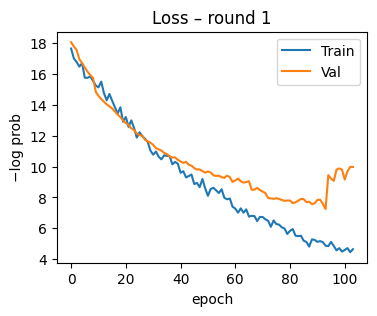

/home/users/ids29/sbi/sbi/inference/posteriors/mcmc_posterior.py:118: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]

Removed no burn in


/tmp/ipykernel_3394657/596311626.py:141: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  markers=np.array(theta_test).flatten())


<Figure size 640x480 with 0 Axes>

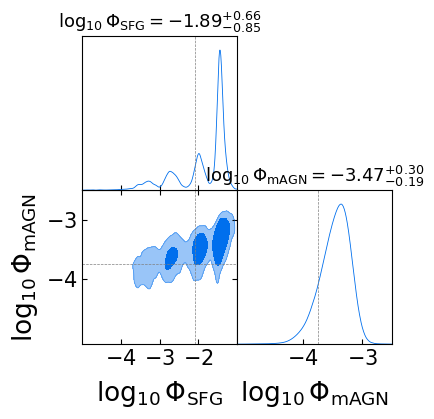


──────────  ROUND 2/10  ──────────


Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5100 [00:00<?, ?it/s]

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
/home/users/ids29/.conda/envs/sbi_env/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=48)]: Done  11 out of  96 | elapsed: 13.8min remaining: 107.0min
[Parallel(n_jobs=48)]: Done  21 out of  96 | elapsed: 14.4min remaining: 51.3min
[Parallel(n_jobs=48)]: Done  31 out of  96 | elapsed: 14.6min remaining: 30.5min
[Parallel(n_jobs=48)]: Done  41 out of  96 | elapsed: 15.0min remaining: 20.2min
[Parallel(n_jobs=48)]: Done  51 out of  96 | elapsed: 27.3min remaining: 24.1min
[Parallel(n_jobs=48)]: Done  61 out of  96 | elapsed: 27.8min remaining: 16.0min
[Parallel(n_jobs=48)]: Done  71 out of  96 | elapsed: 28.4min remaining: 10.0min
[Parallel(n_jobs=48)]: Done  81 out of  96 | elapsed: 28.8min remaining:  5.3min

Using SNPE-C with atomic loss
 Neural network successfully converged after 83 epochs.

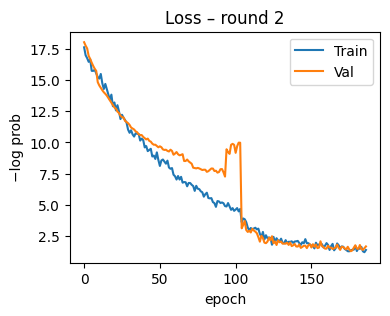

/home/users/ids29/sbi/sbi/inference/posteriors/mcmc_posterior.py:118: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]

Removed no burn in


/tmp/ipykernel_3394657/596311626.py:141: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  markers=np.array(theta_test).flatten())


<Figure size 640x480 with 0 Axes>

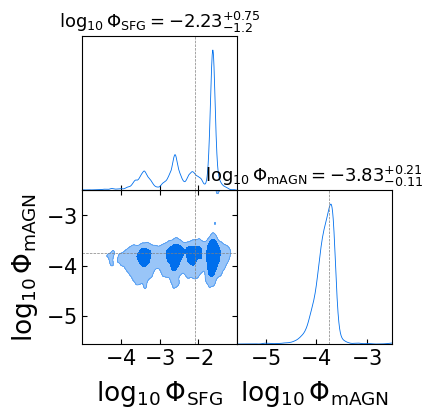


──────────  ROUND 3/10  ──────────


Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5100 [00:00<?, ?it/s]

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  11 out of  96 | elapsed: 13.7min remaining: 106.0min
[Parallel(n_jobs=48)]: Done  21 out of  96 | elapsed: 13.9min remaining: 49.6min
[Parallel(n_jobs=48)]: Done  31 out of  96 | elapsed: 14.2min remaining: 29.9min
[Parallel(n_jobs=48)]: Done  41 out of  96 | elapsed: 14.7min remaining: 19.7min
[Parallel(n_jobs=48)]: Done  51 out of  96 | elapsed: 27.4min remaining: 24.2min
[Parallel(n_jobs=48)]: Done  61 out of  96 | elapsed: 27.7min remaining: 15.9min
[Parallel(n_jobs=48)]: Done  71 out of  96 | elapsed: 28.0min remaining:  9.9min
[Parallel(n_jobs=48)]: Done  81 out of  96 | elapsed: 28.4min remaining:  5.3min
[Parallel(n_jobs=48)]: Done  91 out of  96 | elapsed: 29.0min remaining:  1.6min
[Parallel(n_jobs=48)]: Done  96 out of  96 | elapsed: 29.5min finished


Using SNPE-C with atomic loss
 Neural network successfully converged after 51 epochs.

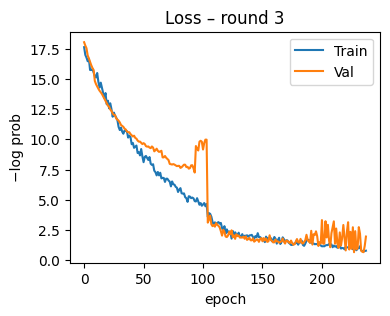

/home/users/ids29/sbi/sbi/inference/posteriors/mcmc_posterior.py:118: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]

Removed no burn in


/tmp/ipykernel_3394657/596311626.py:141: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  markers=np.array(theta_test).flatten())


<Figure size 640x480 with 0 Axes>

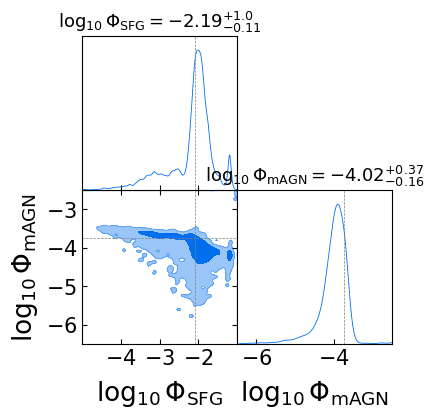


──────────  ROUND 4/10  ──────────


Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5100 [00:00<?, ?it/s]

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  11 out of  96 | elapsed: 13.5min remaining: 104.4min
[Parallel(n_jobs=48)]: Done  21 out of  96 | elapsed: 14.1min remaining: 50.3min
[Parallel(n_jobs=48)]: Done  31 out of  96 | elapsed: 14.2min remaining: 29.8min
[Parallel(n_jobs=48)]: Done  41 out of  96 | elapsed: 14.4min remaining: 19.3min
[Parallel(n_jobs=48)]: Done  51 out of  96 | elapsed: 26.7min remaining: 23.6min
[Parallel(n_jobs=48)]: Done  61 out of  96 | elapsed: 27.6min remaining: 15.9min
[Parallel(n_jobs=48)]: Done  71 out of  96 | elapsed: 27.9min remaining:  9.8min
[Parallel(n_jobs=48)]: Done  81 out of  96 | elapsed: 28.1min remaining:  5.2min
[Parallel(n_jobs=48)]: Done  91 out of  96 | elapsed: 28.9min remaining:  1.6min
[Parallel(n_jobs=48)]: Done  96 out of  96 | elapsed: 29.2min finished


Using SNPE-C with atomic loss
 Neural network successfully converged after 20 epochs.

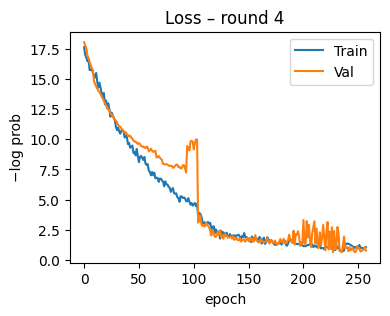

/home/users/ids29/sbi/sbi/inference/posteriors/mcmc_posterior.py:118: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]

Removed no burn in


/tmp/ipykernel_3394657/596311626.py:141: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  markers=np.array(theta_test).flatten())


<Figure size 640x480 with 0 Axes>

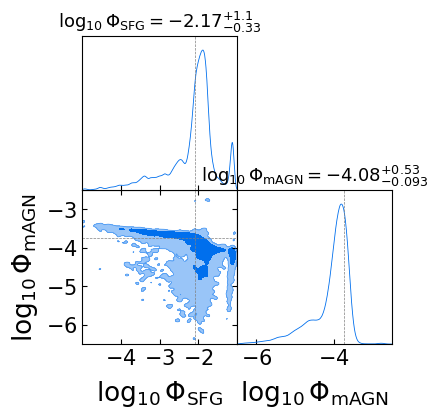


──────────  ROUND 5/10  ──────────


Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5100 [00:00<?, ?it/s]

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  11 out of  96 | elapsed: 13.4min remaining: 103.6min
[Parallel(n_jobs=48)]: Done  21 out of  96 | elapsed: 13.9min remaining: 49.6min
[Parallel(n_jobs=48)]: Done  31 out of  96 | elapsed: 14.1min remaining: 29.5min
[Parallel(n_jobs=48)]: Done  41 out of  96 | elapsed: 14.4min remaining: 19.3min
[Parallel(n_jobs=48)]: Done  51 out of  96 | elapsed: 26.6min remaining: 23.5min
[Parallel(n_jobs=48)]: Done  61 out of  96 | elapsed: 27.3min remaining: 15.6min
[Parallel(n_jobs=48)]: Done  71 out of  96 | elapsed: 27.7min remaining:  9.7min
[Parallel(n_jobs=48)]: Done  81 out of  96 | elapsed: 28.1min remaining:  5.2min
[Parallel(n_jobs=48)]: Done  91 out of  96 | elapsed: 28.8min remaining:  1.6min
[Parallel(n_jobs=48)]: Done  96 out of  96 | elapsed: 29.5min finished


Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.

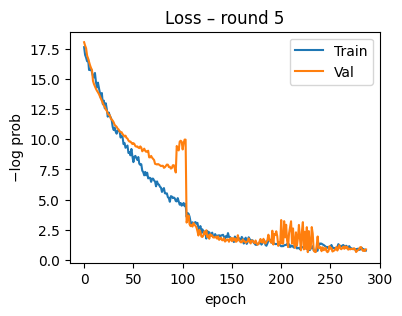

/home/users/ids29/sbi/sbi/inference/posteriors/mcmc_posterior.py:118: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]

Removed no burn in


/tmp/ipykernel_3394657/596311626.py:141: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  markers=np.array(theta_test).flatten())


<Figure size 640x480 with 0 Axes>

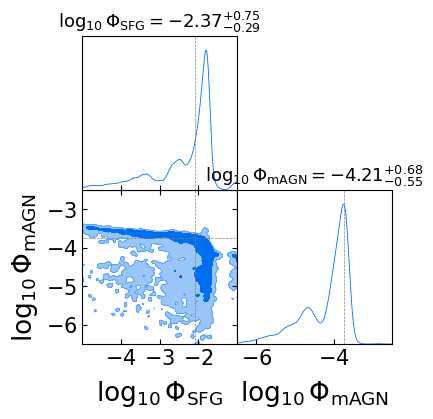


──────────  ROUND 6/10  ──────────


Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5100 [00:00<?, ?it/s]

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  11 out of  96 | elapsed: 13.5min remaining: 104.5min
[Parallel(n_jobs=48)]: Done  21 out of  96 | elapsed: 13.8min remaining: 49.2min
[Parallel(n_jobs=48)]: Done  31 out of  96 | elapsed: 14.0min remaining: 29.4min
[Parallel(n_jobs=48)]: Done  41 out of  96 | elapsed: 14.4min remaining: 19.3min
[Parallel(n_jobs=48)]: Done  51 out of  96 | elapsed: 27.0min remaining: 23.9min
[Parallel(n_jobs=48)]: Done  61 out of  96 | elapsed: 27.2min remaining: 15.6min
[Parallel(n_jobs=48)]: Done  71 out of  96 | elapsed: 27.3min remaining:  9.6min
[Parallel(n_jobs=48)]: Done  81 out of  96 | elapsed: 27.5min remaining:  5.1min
[Parallel(n_jobs=48)]: Done  91 out of  96 | elapsed: 28.6min remaining:  1.6min
[Parallel(n_jobs=48)]: Done  96 out of  96 | elapsed: 29.2min finished


Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.

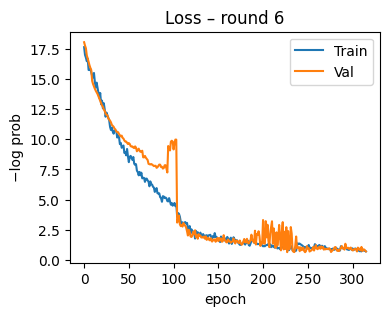

/home/users/ids29/sbi/sbi/inference/posteriors/mcmc_posterior.py:118: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]

Removed no burn in


/tmp/ipykernel_3394657/596311626.py:141: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  markers=np.array(theta_test).flatten())


<Figure size 640x480 with 0 Axes>

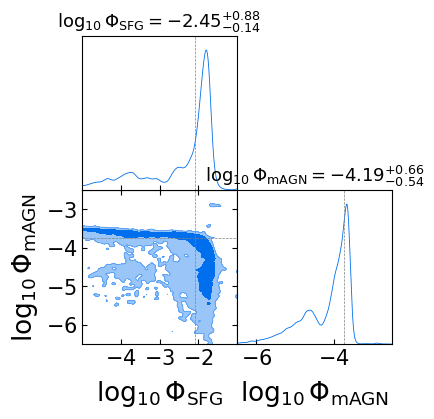


──────────  ROUND 7/10  ──────────


Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5100 [00:00<?, ?it/s]

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  11 out of  96 | elapsed: 13.3min remaining: 103.0min
[Parallel(n_jobs=48)]: Done  21 out of  96 | elapsed: 13.8min remaining: 49.2min
[Parallel(n_jobs=48)]: Done  31 out of  96 | elapsed: 14.0min remaining: 29.3min
[Parallel(n_jobs=48)]: Done  41 out of  96 | elapsed: 14.2min remaining: 19.1min
[Parallel(n_jobs=48)]: Done  51 out of  96 | elapsed: 26.2min remaining: 23.1min
[Parallel(n_jobs=48)]: Done  61 out of  96 | elapsed: 27.1min remaining: 15.5min
[Parallel(n_jobs=48)]: Done  71 out of  96 | elapsed: 27.5min remaining:  9.7min
[Parallel(n_jobs=48)]: Done  81 out of  96 | elapsed: 27.7min remaining:  5.1min
[Parallel(n_jobs=48)]: Done  91 out of  96 | elapsed: 28.8min remaining:  1.6min
[Parallel(n_jobs=48)]: Done  96 out of  96 | elapsed: 29.8min finished


Using SNPE-C with atomic loss
 Neural network successfully converged after 53 epochs.

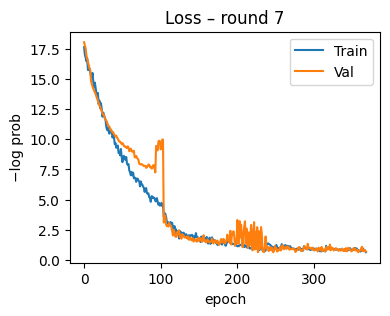

/home/users/ids29/sbi/sbi/inference/posteriors/mcmc_posterior.py:118: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]

Removed no burn in


/tmp/ipykernel_3394657/596311626.py:141: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  markers=np.array(theta_test).flatten())


<Figure size 640x480 with 0 Axes>

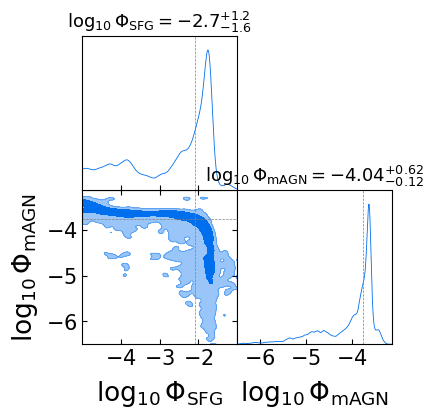


──────────  ROUND 8/10  ──────────


Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5100 [00:00<?, ?it/s]

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  11 out of  96 | elapsed: 19.1min remaining: 148.0min
[Parallel(n_jobs=48)]: Done  21 out of  96 | elapsed: 19.6min remaining: 69.9min
[Parallel(n_jobs=48)]: Done  31 out of  96 | elapsed: 20.4min remaining: 42.8min
[Parallel(n_jobs=48)]: Done  41 out of  96 | elapsed: 23.0min remaining: 30.9min
[Parallel(n_jobs=48)]: Done  51 out of  96 | elapsed: 38.0min remaining: 33.5min
[Parallel(n_jobs=48)]: Done  61 out of  96 | elapsed: 38.9min remaining: 22.3min
[Parallel(n_jobs=48)]: Done  71 out of  96 | elapsed: 40.0min remaining: 14.1min
[Parallel(n_jobs=48)]: Done  81 out of  96 | elapsed: 41.5min remaining:  7.7min
[Parallel(n_jobs=48)]: Done  91 out of  96 | elapsed: 45.3min remaining:  2.5min
[Parallel(n_jobs=48)]: Done  96 out of  96 | elapsed: 50.1min finished


Using SNPE-C with atomic loss
 Neural network successfully converged after 23 epochs.

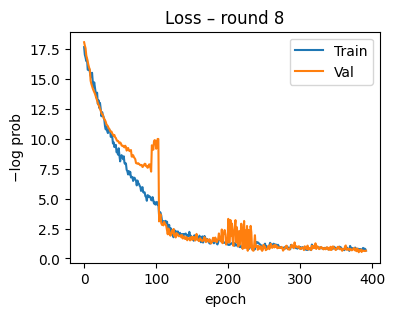

/home/users/ids29/sbi/sbi/inference/posteriors/mcmc_posterior.py:118: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]

Removed no burn in


/tmp/ipykernel_3394657/596311626.py:141: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  markers=np.array(theta_test).flatten())


<Figure size 640x480 with 0 Axes>

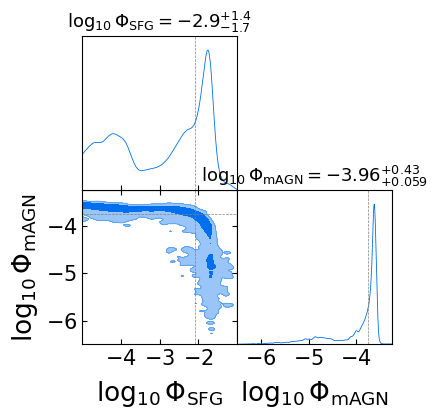


──────────  ROUND 9/10  ──────────


Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5100 [00:00<?, ?it/s]

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  11 out of  96 | elapsed: 19.2min remaining: 148.4min
[Parallel(n_jobs=48)]: Done  21 out of  96 | elapsed: 19.7min remaining: 70.5min
[Parallel(n_jobs=48)]: Done  31 out of  96 | elapsed: 20.4min remaining: 42.8min
[Parallel(n_jobs=48)]: Done  41 out of  96 | elapsed: 22.4min remaining: 30.0min
[Parallel(n_jobs=48)]: Done  51 out of  96 | elapsed: 38.2min remaining: 33.7min
[Parallel(n_jobs=48)]: Done  61 out of  96 | elapsed: 38.8min remaining: 22.3min
[Parallel(n_jobs=48)]: Done  71 out of  96 | elapsed: 39.3min remaining: 13.8min
[Parallel(n_jobs=48)]: Done  81 out of  96 | elapsed: 41.9min remaining:  7.8min
[Parallel(n_jobs=48)]: Done  91 out of  96 | elapsed: 44.6min remaining:  2.5min
[Parallel(n_jobs=48)]: Done  96 out of  96 | elapsed: 48.9min finished


Using SNPE-C with atomic loss
 Neural network successfully converged after 32 epochs.

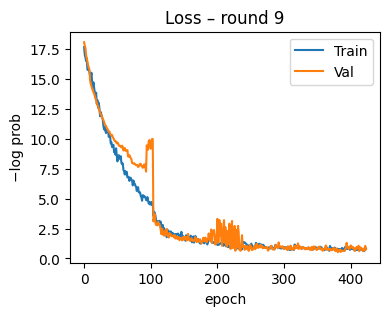

/home/users/ids29/sbi/sbi/inference/posteriors/mcmc_posterior.py:118: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]

Removed no burn in


/tmp/ipykernel_3394657/596311626.py:141: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  markers=np.array(theta_test).flatten())


<Figure size 640x480 with 0 Axes>

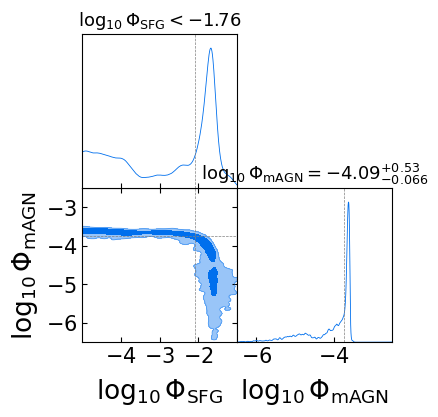


──────────  ROUND 10/10  ──────────


Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/5100 [00:00<?, ?it/s]

[Parallel(n_jobs=48)]: Using backend LokyBackend with 48 concurrent workers.
[Parallel(n_jobs=48)]: Done  11 out of  96 | elapsed: 19.4min remaining: 149.7min
[Parallel(n_jobs=48)]: Done  21 out of  96 | elapsed: 20.1min remaining: 71.8min
[Parallel(n_jobs=48)]: Done  31 out of  96 | elapsed: 22.5min remaining: 47.2min
[Parallel(n_jobs=48)]: Done  41 out of  96 | elapsed: 24.3min remaining: 32.6min
[Parallel(n_jobs=48)]: Done  51 out of  96 | elapsed: 38.2min remaining: 33.7min
[Parallel(n_jobs=48)]: Done  61 out of  96 | elapsed: 39.3min remaining: 22.5min
[Parallel(n_jobs=48)]: Done  71 out of  96 | elapsed: 41.7min remaining: 14.7min
[Parallel(n_jobs=48)]: Done  81 out of  96 | elapsed: 42.8min remaining:  7.9min
[Parallel(n_jobs=48)]: Done  91 out of  96 | elapsed: 45.8min remaining:  2.5min
[Parallel(n_jobs=48)]: Done  96 out of  96 | elapsed: 49.3min finished


Using SNPE-C with atomic loss
 Neural network successfully converged after 12 epochs.

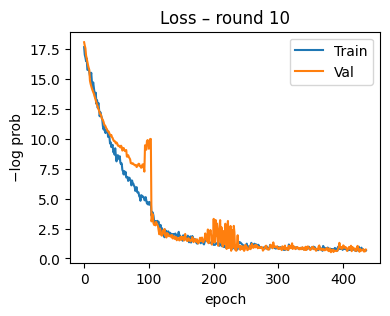

/home/users/ids29/sbi/sbi/inference/posteriors/mcmc_posterior.py:118: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Generating 20 MCMC inits via resample strategy:   0%|          | 0/20 [00:00<?, ?it/s]

Running vectorized MCMC with 20 chains:   0%|          | 0/15000 [00:00<?, ?it/s]

/tmp/ipykernel_3394657/596311626.py:141: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  markers=np.array(theta_test).flatten())


Removed no burn in


<Figure size 640x480 with 0 Axes>

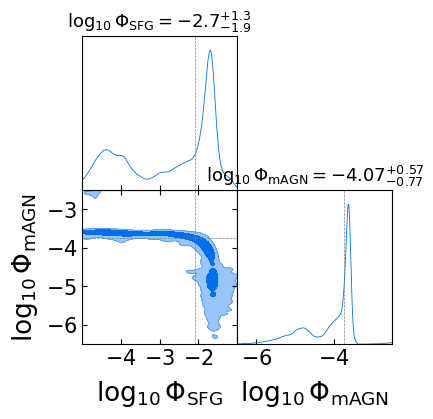


All rounds finished.  Close the figures to exit.


In [ ]:
# ------------------------------------------------------------------ #
# 5.  Initialise
# ------------------------------------------------------------------ #
prior     = utils.BoxUniform(LOW, HIGH, device="cpu")   # cpu for sampling speed
raw_o = simulate_raw_photon_data(theta_test)  # simulate the observed raw data
x_o_full  = compute_summary_statistics(raw_o)       # 1-D tensor  (D_full,)

mean_x, std_x = None, None          # will freeze after round-1
mask_keep      = None               # pruning mask  (booleans over D_full)

Θ_accum, X_accum = [], []           # running simulation database
proposal = prior                    # start broad
plt.ion()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# resume_flag = False   # Nothing to resume yet

for r in range(1, NUM_ROUNDS + 1):
    print(f"\n──────────  ROUND {r}/{NUM_ROUNDS}  ──────────")

    # 5.1  Draw parameters
    if r == 1:
        θ_batch = prior.sample((SIMS_PER_ROUND,))    # (N,2) cpu
    else:
        θ_batch = proposal.sample((SIMS_PER_ROUND,), x=x_o_z).cpu()

    # 5.2  Simulate & summarise
    summaries = []
    # for θ in θ_batch:
    #     raw   = simulate_raw_photon_data(θ)
    #     summ  = compute_summary_statistics(raw)
    #     summaries.append(summ)
    # x_batch_full = torch.stack(summaries)            # (N, D_full)
    
    def simulate_and_summarize(theta):
        raw  = simulate_raw_photon_data(theta)
        return compute_summary_statistics(raw)

    # dispatch 48 parallel jobs
    summaries = Parallel(
        n_jobs=num_workers,           # number of worker processes
        backend="loky",      # default multiprocess backend
        verbose=10           # progress output
    )(
        delayed(simulate_and_summarize)(theta) 
        for theta in θ_batch
    )

    # stack back into a tensor
    x_batch_full = torch.stack(summaries)  # shape: (SIMS_PER_ROUND, D_full)

    # 5.3  Append to global store
    Θ_accum.append(θ_batch)
    X_accum.append(x_batch_full)
    Θ_all = torch.cat(Θ_accum, 0)                    # (N_tot,2)
    X_all_full = torch.cat(X_accum, 0)               # (N_tot,D_full)

    # 5.4  Dimension pruning  (mask fixed after first round)
    if mask_keep is None:
        X_red, x_o_red, mask_keep = reduce_summary(
            X_all_full, x_o_full, Θ_all, thresh=0.10)
        print(f"summary dims: {X_all_full.shape[1]}  →  {X_red.shape[1]} kept")
    else:
        X_red = X_all_full[:, mask_keep]
        x_o_red = x_o_full[mask_keep]

    # 5.5  External z-score  (μ,σ fixed after first round)
    if mean_x is None:
        mean_x = X_red.mean(0)
        std_x  = X_red.std(0).clamp(min=1e-8)
    X_z = (X_red - mean_x) / std_x
    x_o_z = (x_o_red - mean_x) / std_x

    # 5.6  Build / update inference object
    if r == 1:
        # net = posterior_nn(model="nsf", hidden_features=128, num_transforms=8,
        #                    dropout_probability=0.2, use_combined_loss=True,
        #                    z_score_x="none", z_score_theta="none")
        net = posterior_nn(model="nsf", hidden_features=64, num_transforms=4,
                           dropout_probability=0.4, use_combined_loss=True,
                           z_score_x="independent", z_score_theta="none")
        inf = SNPE_C_Custom(prior, net, device=device)
        

    # --- append **only this round’s** simulations and tag them with their proposal ---
    idx0        = Θ_all.shape[0] - SIMS_PER_ROUND      # first row of the current round
    X_z_batch   = X_z[idx0:]                           # shape: (SIMS_PER_ROUND, D_red)

    # proposal must be passed from round 2 onward (None is fine in round 1)
    this_proposal = None if r == 1 else proposal

    inf.append_simulations(
            θ_batch.to(device),        # θ from this round only
            X_z_batch.to(device),      # summaries from this round only
            proposal=this_proposal,
    )


    # inf.append_simulations(Θ_all.to(device), X_z.to(device))



    de = inf.train(
        training_batch_size=32, learning_rate=5e-4,
        validation_fraction=0.2, stop_after_epochs=10, max_num_epochs=500,
        show_train_summary=False, clip_max_norm=1.0,
        optimizer_class=AdamW,
        optimizer_kwargs={"lr": 1e-3, "weight_decay": 1e-4})
        # resume_training=resume_flag)  # <── safe
    
    # resume_flag = True   # from now on the attribute exists

    # 5.7  Loss curves
    hist = inf._summary
    fig_loss = plt.figure(figsize=(4,3))
    plt.plot(hist["training_loss"],   label="Train")
    plt.plot(hist["validation_loss"], label="Val")
    plt.xlabel("epoch"); plt.ylabel("−log prob"); plt.legend()
    plt.title(f"Loss – round {r}")
    plt.show()

    # 5.8  Posterior & sampling
    posterior = inf.build_posterior(de, sample_with="mcmc")
    posterior.set_default_x(x_o_z.to(device))
    samples_np = posterior.sample((POST_SAMPLES,), x=x_o_z.to(device)
                     ).cpu().numpy()

    # 5.9  Triangle plot
    mcs = MCSamples(samples=samples_np, names=["Phi_SFG","Phi_mAGN"],
                    labels=LABELS, ranges=list(zip(LOW.numpy(), HIGH.numpy())))
    fig_corner = plt.figure()
    gp = plots.get_subplot_plotter()
    gp.settings.title_limit_fontsize = 16 # reference size for 3.5 inch subplot
    gp.settings.axes_fontsize=18
    gp.settings.legend_fontsize = 26
    gp.settings.axes_labelsize = 22
    gp.settings.norm_1d_density = True
    gp.settings.title_limit = 1
    gp.triangle_plot(mcs, filled=True,
                     markers=np.array(theta_test).flatten())
    fig_corner.suptitle(f"Posterior – round {r}", y=0.98)
    plt.show()

    # 5.10  Make posterior the next proposal
    proposal = posterior

print("\nAll rounds finished.  Close the figures to exit.")
plt.ioff()